In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib as mpl
from matplotlib import font_manager
import os, glob
import json

# define project directories 
root = os.path.abspath(os.getcwd())

In [2]:
#read in charity data
cc_df = pd.read_csv("registered-charity_20220724.csv")
cc_ch = cc_df[~cc_df["companyNumber"].isna()]

C:\Users\LISA~1.HOR\AppData\Local\Temp/ipykernel_7636/2524972240.py:2: DtypeWarning: Columns (2,3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  cc_df = pd.read_csv("registered-charity_20220724.csv")


In [4]:
sic_section_names = {
    "A": "Agriculture (A)",
    "B": "Mining (B)",
    "C": "Manufacturing (C)",
    "D": "Electricity and Gas (D)", 
    "E": "Water and waste management (E)",
    "F": "Construction (F)",
    "G": "Retail (G)",
    "H": "Transportation (H)",
    "I": "Accommodation and food services (I)",
    "J": "Information and communication (J)",
    "K": "Finance and insurance (K)",
    "L": "Real estate (L)",
    "M": "Scientific and technical activities (M)",
    "N": "Administrative activities (N)",
    "O": "Public administration (O)",
    "P": "Education (P)",
    "Q": "Health and social work (Q)",
    "R": "Arts, entertainment and recreation (R)",
    "S": "Other service activities (S)",
    "T": "Households as employers (T)",
    "U": "Extraterritorial organisations (U)"
    }

In [5]:
sic_section_names_chart = {
    "A": "Agriculture",
    "B": "Mining",
    "C": "Manufacturing",
    "D": "Electricity\nand gas", 
    "E": "Water and waste",
    "F": "Construction",
    "G": "Retail",
    "H": "Transportation",
    "I": "Accommodation/food",
    "J": "Information\n/communication",
    "K": "Finance",
    "L": "Real estate",
    "M": "Scientific and\ntechnical activities",
    "N": "Administration",
    "O": "Public administration",
    "P": "Education",
    "Q": "Health and\nsocial work",
    "R": "Arts and\nrecreation",
    "S": "Other services",
    "T": "Households",
    "U": "Extraterritorial orgs"
    }

In [6]:
f = open('codes.json') 
sic_dict = json.load(f) 

In [272]:
# read in gender pay gap data and merge files
all_files = glob.glob(os.path.join(root, "UK Gender Pay Gap Data*.csv"))

all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('\\')[-1][-16:-4]
    df = pd.merge(df, cc_ch, left_on="CompanyNumber", right_on="companyNumber", how='left')
    all_df.append(df)
    
pay_df = pd.concat(all_df, ignore_index=True, sort=True)

In [8]:
pay_df.to_csv("test.csv")

# Processing

### SIC codes

In [273]:
#clean up SIC codes a bit
pay_df["SIC_clean"] = pay_df["SicCodes"].str.replace("1,", "").str.replace("\n", "")
pay_df["SIC_clean"] = pay_df["SIC_clean"].fillna("")
pay_df["SIC_clean"] = pay_df["SIC_clean"].str.split(",")
pay_df["SIC_count"] = pay_df["SIC_clean"].str.len()

#map against section and industry name from dictionary

section_all = []
name_all = []

for i in range(len(pay_df["SIC_clean"])):
    section = []
    name = []
    for k in range(len(pay_df["SIC_clean"][i])):
        try:
            section.append(sic_dict[pay_df["SIC_clean"][i][k]]["section"])
            name.append(sic_dict[pay_df["SIC_clean"][i][k]]["industry"])
        except KeyError:
            pass
    section_all.append(section)
    name_all.append(name)

#add to dataframe
pay_df["SIC_sections"] = section_all
pay_df["SIC_names"] = name_all

#select first one as the main SIC
pay_df["SIC_section"] = pay_df["SIC_sections"].str[0]
pay_df["SIC_name"] = pay_df["SIC_names"].str[0]

pay_df["SIC_section_name"] = pay_df["SIC_section"].map(sic_section_names)

In [276]:
pay_df["NiceName"] = pay_df["EmployerName"].str.title()

In [275]:
#Tech specific codes
tech = [ "58290", "62011", "62012", "62020", "62030",  "63110", "63120"]

#62090 exclude other technology services 

for code in tech:
    pay_df.loc[pay_df["SicCodes"].str.contains(code, na=False), "Sector"] = "Tech"

pay_df.loc[(pay_df["SicCodes"].str.contains("78300", na=False)) & 
           (len(pay_df["SIC_sections"])==1), "Sector"] = None

In [119]:
tech_support = pay_df.loc[pay_df["SicCodes"].str.contains("62030", na=False)][["CompanyLinkToGPGInfo",
                                                                               "CompanyNumber", 
                                                                "CurrentName","SicCodes", "Sector"]].drop_duplicates()

#tech_support.to_csv("tech_support.csv")
tech_support

,CompanyLinkToGPGInfo,CompanyNumber,CurrentName,SicCodes,Sector
313,https://www.allegisglobalsolutions.com/en-gb/c...,03550830,ALLEGIS GLOBAL SOLUTIONS LIMITED,"62030,\n78109,\n78200,\n78300",None
314,https://www.allegisgroup.com/en-gb/legal,02876353,ALLEGIS GROUP LIMITED,"62030,\n78109,\n78200,\n78300",None
472,https://www.ans.co.uk/about/,03176761,ANS GROUP LIMITED,"61900,\n62020,\n62030,\n62090",Tech
1722,https://www.ccsmedia.com/media/CCS-Media-Our-G...,01693516,CCS BOTTOMCO LIMITED,62030,Tech
2950,https://www.ensono.com/uk/about-us/careers/gen...,03276974,ENSONO LIMITED,"62020,\n62030,\n62090,\n63110",Tech
4333,https://cic-uk.eu-gb.mybluemix.net/pages/repor...,09360752,IBM SERVICES CENTRE UK LIMITED,"62012,\n62020,\n62030,\n63120",Tech
4344,NaN,02758710,IDE GROUP MANAGE LIMITED,62030,Tech
4572,https://www.itcinfotech.com/wp-content/uploads...,02777705,ITC INFOTECH LIMITED,"62012,\n62020,\n62030,\n62090",Tech
4901,https://www.cloud9umbrella.com/modern-slavery-...,08156779,HAMRAN MANAGEMENT LIMITED,62030,Tech
6496,https://www.oracle.com/goto/gpg-report,01782505,ORACLE CORPORATION UK LIMITED,"62012,\n62020,\n62030,\n63110",Tech


### Clean employername

In [11]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby(["file", "SIC_section_name"])[['DiffMeanHourlyPercent','DiffMedianHourlyPercent' ,
                                                           'DiffMeanBonusPercent', 'DiffMedianBonusPercent' ]].mean()
pivot

DiffMeanHourlyPercent  \
file         SIC_section_name                                                 
2021 to 2022 Accommodation and food services (I)                   8.065885   
             Administrative activities (N)                         9.804222   
             Arts, entertainment and recreation (R)               22.324107   
             Construction (F)                                     20.053169   
             Education (P)                                        16.049583   
             Finance and insurance (K)                            24.949884   
             Health and social work (Q)                            9.910315   
             Information and communication (J)                    17.821158   
             Manufacturing (C)                                    10.689612   
             Public administration (O)                             6.425502   
             Retail (G)                                           14.039179   
             Scientific and technical activities (M)              18.184746   
             Transportation (H)                                    9.155467   

                                                      DiffMedianHourlyPercent  \
file         SIC_section_name                                                   
2021 to 2022 Accommodation and food services (I)                     4.581237   
             Administrative activities (N)                           8.432806   
             Arts, entertainment and recreation (R)                  4.953571   
             Construction (F)                                       22.062324   
             Education (P)                                          23.590917   
             Finance and insurance (K)                              22.209049   
             Health and social work (Q)                              5.023561   
             Information and communication (J)                      16.436128   
             Manufacturing (C)                                       8.451008   
             Public administration (O)                               6.015462   
             Retail (G)                                              8.644728   
             Scientific and technical activities (M)                15.465113   
             Transportation (H)                                      8.912000   

                                                      DiffMeanBonusPercent  \
file         SIC_section_name                                                
2021 to 2022 Accommodation and food services (I)                 16.730532   
             Administrative activities (N)                       13.688840   
             Arts, entertainment and recreation (R)              24.597122   
             Construction (F)                                    16.675391   
             Education (P)                                       17.185397   
             Finance and insurance (K)                           36.818029   
             Health and social work (Q)                          10.276732   
             Information and communication (J)                   27.239095   
             Manufacturing (C)                                   21.622801   
             Public administration (O)                            2.542986   
             Retail (G)                                          25.227536   
             Scientific and technical activities (M)             27.293185   
             Transportation (H)                                  16.738393   

                                                      DiffMedianBonusPercent  
file         SIC_section_name                                                 
2021 to 2022 Accommodation and food services (I)                    2.542297  
             Administrative activities (N)                        -17.991050  
             Arts, entertainment and recreation (R)                12.642446  
             Construction (F)                                     -36.842188  
       

In [11]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby(["file", "SIC_section_name"])[['DiffMeanHourlyPercent','DiffMedianHourlyPercent' ,
                                                           'DiffMeanBonusPercent', 'DiffMedianBonusPercent' ]].count()
pivot

DiffMeanHourlyPercent  \
file         SIC_section_name                                                 
2021 to 2022 Accommodation and food services (I)                        469   
             Administrative activities (N)                             1137   
             Arts, entertainment and recreation (R)                     224   
             Construction (F)                                           284   
             Education (P)                                             1200   
             Finance and insurance (K)                                  431   
             Health and social work (Q)                                 921   
             Information and communication (J)                          501   
             Manufacturing (C)                                         1290   
             Public administration (O)                                  498   
             Retail (G)                                                 901   
             Scientific and technical activities (M)                    708   
             Transportation (H)                                         375   

                                                      DiffMedianHourlyPercent  \
file         SIC_section_name                                                   
2021 to 2022 Accommodation and food services (I)                          469   
             Administrative activities (N)                               1137   
             Arts, entertainment and recreation (R)                       224   
             Construction (F)                                             284   
             Education (P)                                               1200   
             Finance and insurance (K)                                    431   
             Health and social work (Q)                                   921   
             Information and communication (J)                            501   
             Manufacturing (C)                                           1290   
             Public administration (O)                                    498   
             Retail (G)                                                   901   
             Scientific and technical activities (M)                      708   
             Transportation (H)                                           375   

                                                      DiffMeanBonusPercent  \
file         SIC_section_name                                                
2021 to 2022 Accommodation and food services (I)                       357   
             Administrative activities (N)                             905   
             Arts, entertainment and recreation (R)                    139   
             Construction (F)                                          256   
             Education (P)                                             315   
             Finance and insurance (K)                                 416   
             Health and social work (Q)                                563   
             Information and communication (J)                         486   
             Manufacturing (C)                                        1171   
             Public administration (O)                                 221   
             Retail (G)                                                828   
             Scientific and technical activities (M)                   631   
             Transportation (H)                                        336   

                                                      DiffMedianBonusPercent  
file         SIC_section_name                                                 
2021 to 2022 Accommodation and food services (I)                         357  
             Administrative activities (N)                               905  
             Arts, entertainment and recreation (R)                      139  
             Construction (F)                                            256  
       

In [12]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby([ "SIC_section_name"])[[ 'FemaleLowerQuartile', 
                                                               'FemaleLowerMiddleQuartile',
                                                               'FemaleUpperMiddleQuartile',
                                                               'FemaleTopQuartile' ]].mean()
pivot = pivot.sort_values(by="FemaleTopQuartile", ascending=False)
pivot

,FemaleLowerQuartile,FemaleLowerMiddleQuartile,FemaleUpperMiddleQuartile,FemaleTopQuartile
SIC_section_name,,,,
Health and social work (Q),77.768681,78.037253,77.337692,72.278571
Education (P),79.766413,75.312098,69.788663,63.589509
Public administration (O),57.384553,56.384959,54.008537,48.978659
Accommodation and food services (I),54.476667,51.524444,49.656222,45.302000
Administrative activities (N),50.779216,46.686326,42.660073,37.892069
"Arts, entertainment and recreation (R)",45.900000,44.983886,42.202370,35.267299
Retail (G),47.181561,45.842986,41.152376,35.249434
Scientific and technical activities (M),53.150860,48.021347,42.424785,34.577364
Finance and insurance (K),57.276102,50.431090,41.544084,30.673782


## Proportion of women per pay band by industry

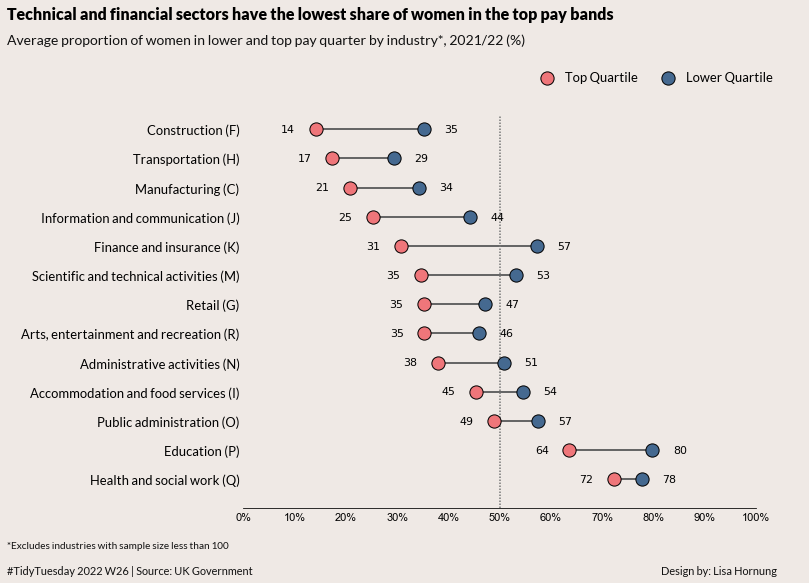

In [81]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby([ "SIC_section_name"])[[ 'FemaleLowerQuartile', 
                                                               'FemaleLowerMiddleQuartile',
                                                               'FemaleUpperMiddleQuartile',
                                                               'FemaleTopQuartile' ]].mean()
data = pivot.sort_values(by="FemaleTopQuartile", ascending=False)

## Charts
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Lato-Black.ttf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Lato-Regular.ttf')
colours = ["#ef767a","#456990", "#56cfe1"]

# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(8,7))
fig.set_facecolor("#efe9e5")
 
#make plot area transparent
plt.subplots_adjust(left=0.01, bottom=0.08, right=0.9, top=0.90, wspace=None, hspace=None)
plt.gca().patch.set_alpha(0) 

#remove grid
for pos in ['right', 'top',  'left']:
    ax.spines[pos].set_visible(False)

# ===========
# plot data                  
my_range=range(1,len(data.index)+1)

# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=data['FemaleLowerQuartile'], xmax=data['FemaleTopQuartile'],linewidth=2, 
           color='#666666', alpha=1, zorder=2)
plt.scatter(data['FemaleTopQuartile'], my_range, s=175, linewidth=1, edgecolors='black', 
            alpha=1, label='Top Quartile', zorder=3, color=colours[0])
plt.scatter(data['FemaleLowerQuartile'], my_range, s=175, linewidth=1, edgecolors='black', 
            alpha=1 , label='Lower Quartile', zorder=3, color=colours[1])

#==========
#annotation
plt.plot([50, 50], [0,len(data)+0.5],linestyle= (0,(1,1)), linewidth=1.5, color='#777777')

for i, values in enumerate(data['FemaleTopQuartile']):
    #if data.index[i].isin(['Information and communication (J)',])
    plt.text(values -4, my_range[i],'{:,.0f}'.format(values), fontsize = 11, weight = 'regular',  
             color='black', va='center', ha='right')
for i, values in enumerate(data['FemaleLowerQuartile']):   
    plt.text(values +4, my_range[i],'{:,.0f}'.format(values), fontsize = 11, weight = 'regular',  
             color='black', va='center', ha='left')

# ==========
#y-axis
plt.tick_params(axis='both', length = 0, color = "#444444")
plt.gca().set_ylim(ymin=0)
plt.yticks(my_range, data.index, fontsize=13, fontproperties=label_font)

#x-axis
plt.xticks(np.arange(0,110,10), fontfamily='Arial')
plt.tick_params(axis='x', labelsize=11)
plt.gca().set_xlim(xmin=0, xmax=100)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}%'.format(x)))

# ==========
#legend
L = ax.legend(ncol=2, frameon=False, loc='upper right',bbox_to_anchor=(1.05,1.08))
plt.setp(L.texts, fontfamily="Lato", fontsize=13)

# ==========
# Title and footer
plt.figtext(-0.4,1.05,'Technical and financial sectors have the lowest share of women in the top pay bands',
         fontsize = 16, weight = 'bold', fontproperties=title_font, color='black')
plt.figtext(-0.4,1, "Average proportion of women in lower and top pay quarter by industry*, 2021/22 (%)", 
            fontproperties=label_font,
            fontsize=14, ha='left',  color="#111111", fontfamily="Lato")

#footer
plt.figtext(-0.4,-0.0, "*Excludes industries with sample size less than 100",
            fontsize=10, ha='left', color="#111111", fontfamily="Lato")
plt.figtext(-0.4,-0.05, "#TidyTuesday 2022 W26 | Source: UK Government", fontsize=11,
            ha='left', color="#111111", fontfamily="Lato")
plt.figtext(0.98,-0.05, "Design by: Lisa Hornung            ",
            fontsize=11, ha='right', color="#111111", fontfamily="Lato")

# ==========
#save
plt.savefig("Women_share_top_low_pay_band_by_industry.png", bbox_inches="tight",pad_inches=0.2)

# Show the graph

plt.show()

## Median pay difference by industry

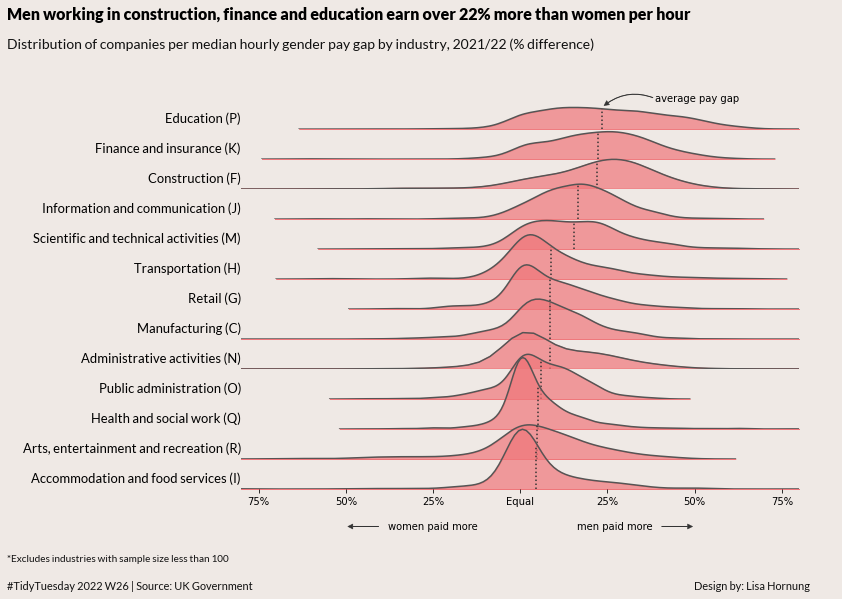

In [131]:
# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor("#efe9e5")

#data
data = pay_df[(pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))]

_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
mean_data = pay_df[_filter].groupby(["SIC_section_name"])[['DiffMedianHourlyPercent' ,
                                                    'DiffMedianBonusPercent' ]].mean().sort_values(by="DiffMedianHourlyPercent",
                                                                                                    ascending=False)

#set colours and font
colours = ["#ef767a","#456990", "#56cfe1"]
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Lato-Black.ttf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Lato-Regular.ttf')

#define arrow style
style = "Simple, tail_width=0.5, head_width=5, head_length=5"
kw = dict(arrowstyle=style, color="#333333")

# =======
#plot data for each age bracket
num=0
for i in mean_data.index:
    num+=1
    plt.subplot(13,1,num)
    plt.gca().patch.set_alpha(0)
    
    g = sns.kdeplot(data[data["SIC_section_name"]==i]['DiffMedianHourlyPercent' ], fill=True, alpha=0.7, color=colours[0])
    g = sns.kdeplot(data[data["SIC_section_name"]==i]['DiffMedianHourlyPercent' ], color="#555555", lw=1.5)
    
    ### Axis
    plt.gca().set_xlim(xmin=-80, xmax=80)
    plt.gca().set_ylim(ymin=0, ymax=0.07)
    
    if num < len(pivot):
        plt.axis('off')
    
    else: 
        
        ## Format bottom axis
        for pos in ["top", "bottom", "right", "left"]:
            plt.gca().spines[pos].set_visible(False)
        plt.grid(visible=False, axis='both')
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().set_xlabel("")
        plt.xticks([-75, -50, -25, 0, 25, 50, 75], ["75%", "50%", "25%", "Equal", "25%", "50%", "75%"])
        
        ### add arrows    
        a1 = mpl.patches.FancyArrowPatch((-40, -0.035), (-50, -0.035),clip_on=False, linewidth=0.5,
                                connectionstyle="arc3,rad=0", **kw)
        a2 = mpl.patches.FancyArrowPatch((40, -0.035), (50, -0.035),clip_on=False, linewidth=0.5,
                                    connectionstyle="arc3,rad=0", **kw)  
        #add 
        for a in [a1,a2]:
            plt.gca().add_patch(a)
            
        ## add annotation
        plt.text(-38, -0.035, "women paid more", va='center', fontsize=10)
        plt.text(38, -0.035, "men paid more", va='center', fontsize=10, ha='right')
   
    ### Mean value line
    #get kde values to add line to show average
    kde_values = pd.DataFrame(g.get_children()[1].get_path().vertices).rename(columns={0:"x", 1: "y"})
    mean = mean_data["DiffMedianHourlyPercent"][i]
    x_pos, y_pos = kde_values[kde_values["x"]>=mean].iloc[0]
    plt.plot([mean,mean], [0, y_pos], linewidth=1.5, linestyle='dotted', color = "#333333")
    
    ## annotation for top mean value
    if num ==1:
        plt.gca().add_patch(mpl.patches.FancyArrowPatch((mean+15, y_pos+0.01), (mean, y_pos+0.002),clip_on=False, linewidth=0.5,
                                    connectionstyle="arc3,rad=0.3", **kw))
        plt.text(mean+15, y_pos+0.01, "average pay gap", va='center')
      
    ### Title
    ymin, ymax = plt.gca().get_ylim()
    plt.text(-80,ymax/11, i, fontsize = 13, ha='right', fontproperties=label_font,)

fig.subplots_adjust(hspace=-0.6)
    
# ==========
# Title and footer
plt.figtext(-0.2,0.94,'Men working in construction, finance and education earn over 22% more than women per hour',
         fontsize = 16, weight = 'bold', fontproperties=title_font, color='black')
plt.figtext(-0.2,0.89, "Distribution of companies per median hourly gender pay gap by industry, 2021/22 (% difference)", 
            fontproperties=label_font,  fontsize=14, ha='left',  color="#111111", fontfamily="Lato")

#footer
plt.figtext(-0.2,-0.0, "*Excludes industries with sample size less than 100",
            fontsize=10, ha='left', color="#111111", fontfamily="Lato")
plt.figtext(-0.2,-0.05, "#TidyTuesday 2022 W26 | Source: UK Government", fontsize=11,
            ha='left', color="#111111", fontfamily="Lato")
plt.figtext(0.95,-0.05, "Design by: Lisa Hornung            ",
            fontsize=11, ha='right', color="#111111", fontfamily="Lato")

# ==========
#save
plt.savefig("Distribution_median_hourly_pay_gap_by_industry.png", bbox_inches="tight",pad_inches=0.2)

plt.show()

## Pay gap versus representation

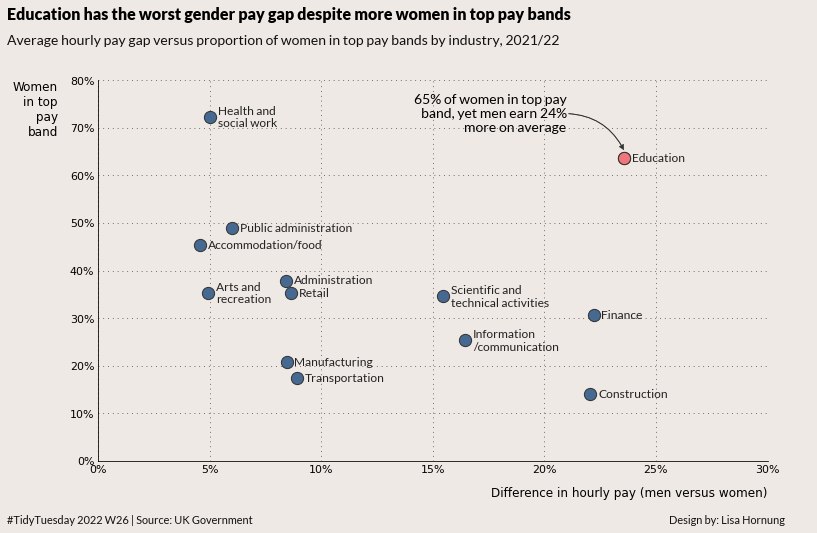

In [233]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
data = pay_df[_filter].groupby([ "SIC_section"])[['DiffMedianHourlyPercent','FemaleTopQuartile']].mean()

# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(12,7))
fig.set_facecolor("#efe9e5")
ax.set_facecolor("#efe9e5")

#data
x = data['DiffMedianHourlyPercent']
y = data['FemaleTopQuartile']
labels = data.index.map(sic_section_names_chart)

#plot data
plt.scatter(x, y, s=150, linewidth=1, alpha=1, color=colours[1], zorder=2, edgecolors="#333333")
plt.scatter(x[10], y[10], s=150, linewidth=1, alpha=1, color=colours[0], zorder=2, edgecolors="#333333")

#add labels
for i in range(len(data)):
    plt.text(x[i]+0.35 ,y[i], labels[i], zorder=2, 
             fontproperties=label_font, size=12, va='center', color="#222222")

    
# =======
#style graph
for pos in ["top", "right"]:
    ax.spines[pos].set_visible(False)
ax.tick_params(axis='both', length = 0, color = "#111111", labelsize=11)
ax.grid(visible=True, axis='both', zorder=1, color = "#333333", linestyle=(0,(1,5)))


#axis
ax.set_ylim(ymin=0, ymax=80)
ax.set_xlim(xmin=0, xmax=30)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}%'.format(x)))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}%'.format(x)))

# Adding and styling axis labels
plt.xlabel('Difference in hourly pay (men versus women)', loc='right', size=12, labelpad=12)
plt.ylabel('Women\nin top\n pay\nband', loc='top', va='top', size=12,
           labelpad=12, rotation=0)


### Annotation
### add arrows
style = "Simple, tail_width=0.5, head_width=5, head_length=5"
kw = dict(arrowstyle=style, color="#333333")
a1 = mpl.patches.FancyArrowPatch((21, 73), (23.6, 65),clip_on=False, linewidth=0.5,
                        connectionstyle="arc3,rad=-0.3", **kw)
plt.gca().add_patch(a1)
plt.text(21, 73, "65% of women in top pay\nband, yet men earn 24%\nmore on average", va='center', ha='right', fontsize=14, fontproperties=label_font)

# ==========
# Title and footer
plt.figtext(0.02,1,'Education has the worst gender pay gap despite more women in top pay bands',
         fontsize = 16, weight = 'bold', fontproperties=title_font, color='black')
plt.figtext(0.02,0.95, "Average hourly pay gap versus proportion of women in top pay bands by industry, 2021/22", 
            fontproperties=label_font,  fontsize=14, ha='left',  color="#111111", fontfamily="Lato")

#footer
plt.figtext(0.02,0, "#TidyTuesday 2022 W26 | Source: UK Government", fontsize=11,
            ha='left', color="#111111", fontfamily="Lato")
plt.figtext(0.95,0, "Design by: Lisa Hornung            ",
            fontsize=11, ha='right', color="#111111", fontfamily="Lato")

# ==========
#save
plt.savefig("Median_hourly_pay_gap_versus_women_top_pay_band_by_industry.png", bbox_inches="tight",pad_inches=0.2)

plt.show()

# Tech vs charities

In [210]:
def get_coords_for_beeswarm(df, values):
    df = df.sort_values(by=values).reset_index(drop=True)
    #df["x"] = round(df[values] * 2) / 2
    df["x"] = [math.floor(x) for x in df[values]]
    df['y_start'] = (df["x"].groupby(df["x"]).transform('count') - 1)/2 *-1
    y_value = []
    for i in range(len(df["x"])):
        if i == 0:
            num = df["y_start"][i]
        elif df["x"][i] == df["x"][i-1]:
            num+=1
        else:
            num = df["y_start"][i]
        y_value.append(num)
    df["y"] = y_value
    return df

In [203]:
_filter = (pay_df["Sector"]=="Tech") & (pay_df["file"] == "2021 to 2022")

table = pay_df[_filter][['CompanyNumber', 'NiceName', 'DiffMedianHourlyPercent', "EmployerSize"]]

#get x and y values for beeswarm plot
table = get_coords_for_beeswarm(table, 'DiffMedianHourlyPercent' )

table.to_csv("tech_companies_gender_pay_gap_2020-21.csv")

table

,CompanyNumber,NiceName,DiffMedianHourlyPercent,EmployerSize,x,y_start,y
0,07795137,Cooper Parry Group Limited,-19.4,250 to 499,-20,-0.0,-0.0
1,01459419,Flooid Limited,-16.0,Less than 250,-16,-0.0,-0.0
2,02542980,Fdm Group Limited,-9.6,"5000 to 19,999",-10,-0.0,-0.0
3,SC077144,Intelligent Office Uk Limited,-8.2,500 to 999,-9,-0.0,-0.0
4,08933499,Oh Goodlord Ltd,-7.0,Less than 250,-7,-0.5,-0.5
...,...,...,...,...,...,...,...
220,01870679,Broadridge Financial Solutions Limited,40.1,500 to 999,40,-0.0,-0.0
221,00968498,Nec Software Solutions Uk Limited,42.0,1000 to 4999,42,-0.5,-0.5
222,02348923,Acora Limited,42.4,250 to 499,42,-0.5,0.5
223,04570027,Fortinet Uk Limited,47.7,250 to 499,47,-0.0,-0.0


### Gender pay gap in Tech companies

In [269]:
def format_axis():
    plt.gca().set_facecolor("#efe9e5")
    for pos in ["top", "right", "bottom", "left"]:
        plt.gca().spines[pos].set_visible(False)
    plt.gca().tick_params(axis='both', length = 0, color = "#111111", labelsize=10)
    #plt.gca().grid(visible=True, axis='x', zorder=1, color = "#333333", linestyle=(0,(1,5)))
    plt.grid(visible=False, axis='both')
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_xlabel("")
    plt.gca().set_xlim(xmin=-25, xmax=50)
    plt.gca().set_ylim(ymin=-10, ymax=10)
    plt.gca().set_xticks([ -25, 0, 25, 50], [ "25%", "Equal",
                                                       "25%", "50%"])

AttributeError: 'str' object has no attribute 'str'

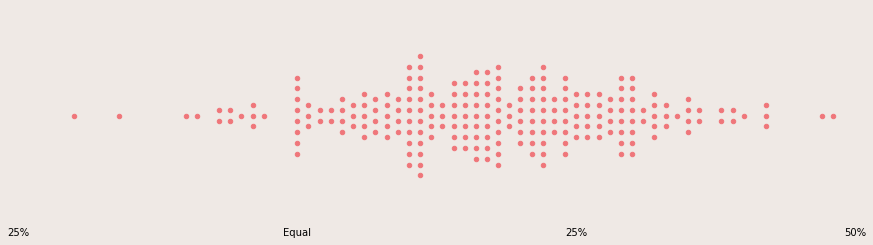

In [280]:
colours = ["#ef767a","#456990", "#56cfe1"]

# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(15,4))
fig.set_facecolor("#efe9e5")

## PLOT 1
#Tech companies
tech_gap = pay_df[(pay_df["Sector"]=="Tech") & (pay_df["file"] == "2021 to 2022")][['CompanyNumber', 'NiceName', 'DiffMedianHourlyPercent']]
tech_gap = get_coords_for_beeswarm(tech_gap, 'DiffMedianHourlyPercent' )

plt.scatter(tech_gap["x"], tech_gap["y"], s=20, color=colours[0], alpha=1)
format_axis()

#add highlights
for i in range(len(tech_gap)):
    
    if tech_gap["NiceName"][i].str.isin([ "Fortinet Uk Limited", "Netapp Uk Ltd", "Rightmove Group Limited"]):
        plt.scatter(tech_gap["x"][i], tech_gap["y"][i], s=20, color=colours[0], alpha=1, edgecolor='black')

## add annotation
plt.text(-20, -13, "women paid more", va='center', fontsize=12)
plt.text(20, -13, "men paid more", va='center', fontsize=12, ha='right')

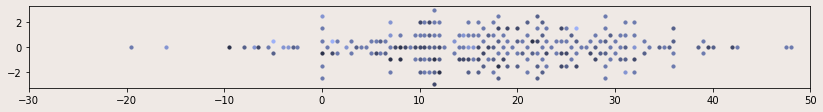

In [179]:
colours = {'Not Provided': "#9CB0F8", 'Less than 250': "#8394D2", '250 to 499' : "#6C7AAE" , '500 to 999': "#55608A",
           '1000 to 4999': "#404869", '5000 to 19,999':  "#2B3149",
         '20,000 or more': "#181B2B" }
 
tech_gap = table[['NiceName', "x", "y", "EmployerSize"]]


# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(14,1.5))
fig.set_facecolor("#efe9e5")
ax.set_facecolor("#efe9e5")

#for i in range(len)
for i in range(len(tech_gap)):
    plt.scatter(tech_gap["x"][i], tech_gap["y"][i], s=10, color=colours[tech_gap["EmployerSize"][i]])

plt.gca().set_xlim(xmin=-30, xmax=50)
plt.show()

In [197]:

        
        ## add annotation
    #plt.text(-38, -0.035, "women paid more", va='center', fontsize=10)
    #plt.text(38, -0.035, "men paid more", va='center', fontsize=10, ha='right')

604


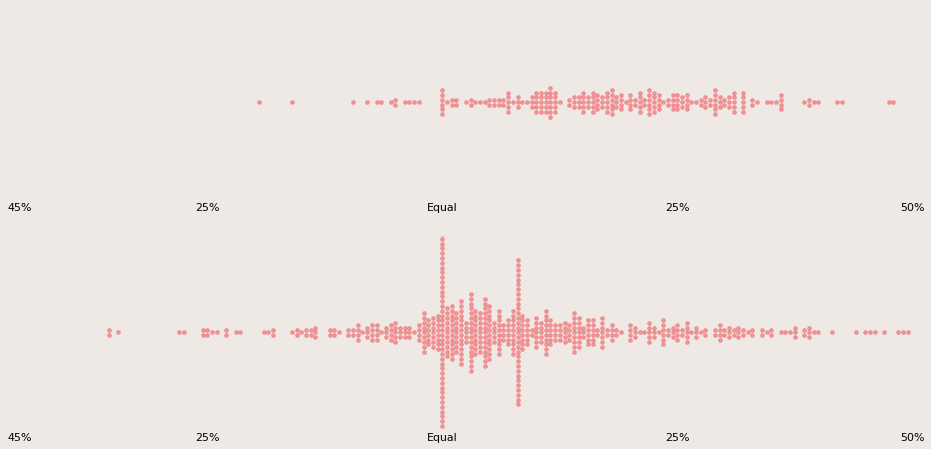

In [201]:
colours = ["#ef767a","#456990", "#56cfe1"]
# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(16,12))
fig.set_facecolor("#efe9e5")

## PLOT 1
#Tech companies
plt.subplot(3,1,1)
tech_gap = pay_df[(pay_df["Sector"]=="Tech") & (pay_df["file"] == "2021 to 2022")][['CompanyNumber', 'NiceName', 'DiffMedianHourlyPercent']]
tech_gap = get_coords_for_beeswarm(tech_gap, 'DiffMedianHourlyPercent' )

plt.scatter(tech_gap["x"], tech_gap["y"], s=13, color=colours[0], alpha=0.7)
format_axis()

## PLOT 1
#Charities
plt.subplot(3,1,2)
char_gap = pay_df[(~pay_df["charityNumber"].isna()) & (pay_df["file"] == "2021 to 2022")][['CompanyNumber', 'NiceName', 'DiffMedianHourlyPercent']]
char_gap = get_coords_for_beeswarm(char_gap, 'DiffMedianHourlyPercent' )
#char_gap = char_gap[~char_gap["x"].isin([0])]

plt.scatter(char_gap["x"], char_gap["y"], s=13, color=colours[0], alpha=0.7)
format_axis()
print(len(char_gap))
plt.show()

In [156]:
pay_df[(~pay_df["charityNumber"].isna()) & (pay_df["file"] == "2021 to 2022")]["charityNumber"]

38251    1145141
38253    1084866
38314    1117138
38315     200719
38344    1071298
          ...   
48638     306122
48640    1079570
48641    1090981
48642    1041923
48643    1069810
Name: charityNumber, Length: 604, dtype: object

In [151]:
pay_df.columns

Index(['Address', 'CompanyLinkToGPGInfo', 'CompanyNumber', 'CurrentName',
       'DateSubmitted', 'DiffMeanBonusPercent', 'DiffMeanHourlyPercent',
       'DiffMedianBonusPercent', 'DiffMedianHourlyPercent', 'DueDate',
       'EmployerId', 'EmployerName', 'EmployerSize', 'FemaleBonusPercent',
       'FemaleLowerMiddleQuartile', 'FemaleLowerQuartile', 'FemaleTopQuartile',
       'FemaleUpperMiddleQuartile', 'MaleBonusPercent',
       'MaleLowerMiddleQuartile', 'MaleLowerQuartile', 'MaleTopQuartile',
       'MaleUpperMiddleQuartile', 'PostCode', 'ResponsiblePerson', 'SicCodes',
       'SubmittedAfterTheDeadline', 'active', 'charityNumber', 'companyNumber',
       'dateModified', 'dateRegistered', 'dateRemoved', 'file', 'id',
       'latestIncome', 'latestIncomeDate', 'linked_orgs', 'name', 'orgIDs',
       'organisationType', 'organisationTypePrimary', 'postalCode', 'source',
       'url', 'SIC_clean', 'SIC_count', 'SIC_sections', 'SIC_names',
       'SIC_section', 'SIC_name', 'SIC_sectio